In [2]:
%pip install PyWavelets

   ---------------------------------------- 0.0/4.2 MB ? eta -:--:--
   ---------------------------------------- 4.2/4.2 MB 50.7 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [28]:
import importlib
import model 
importlib.reload(model)

import main 
importlib.reload(main)


🚀 Using device: cuda


<module 'main' from 'c:\\Users\\janav\\Documents\\load forecasting\\local-stlf\\wavelet-transform\\main.py'>

In [29]:
from main import prepare_data

# --- CONFIGURATION ---
args = {
    "test": 0.3,       # test/val split ratio
    "val": 0.1, 
    "s": 8,        # target sequence length
    "w": 16,        # input sequence window
    "level": 3,     # user-defined max SWT level
    "wavelet": "db2"
}

train_loader, val_loader, test_loader, y_test, scalers_X, scalers_y, X_train_tensors, X_val_tensors, X_test_tensors = prepare_data(args)


In [19]:
def plot_input_bands_from_tensors(X_train_tensors, n_samples=5):
    import matplotlib.pyplot as plt

    n_bands = len(X_train_tensors)
    fig, axs = plt.subplots(n_samples, n_bands, figsize=(4 * n_bands, 3 * n_samples), squeeze=False)

    for i in range(n_samples):
        for j in range(n_bands):
            seq = X_train_tensors[j][i].cpu().detach().numpy().squeeze()
            axs[i][j].plot(seq)
            axs[i][j].set_title(f"Sample {i}, Band {j}")
            axs[i][j].grid(True)

    plt.tight_layout()
    plt.show()


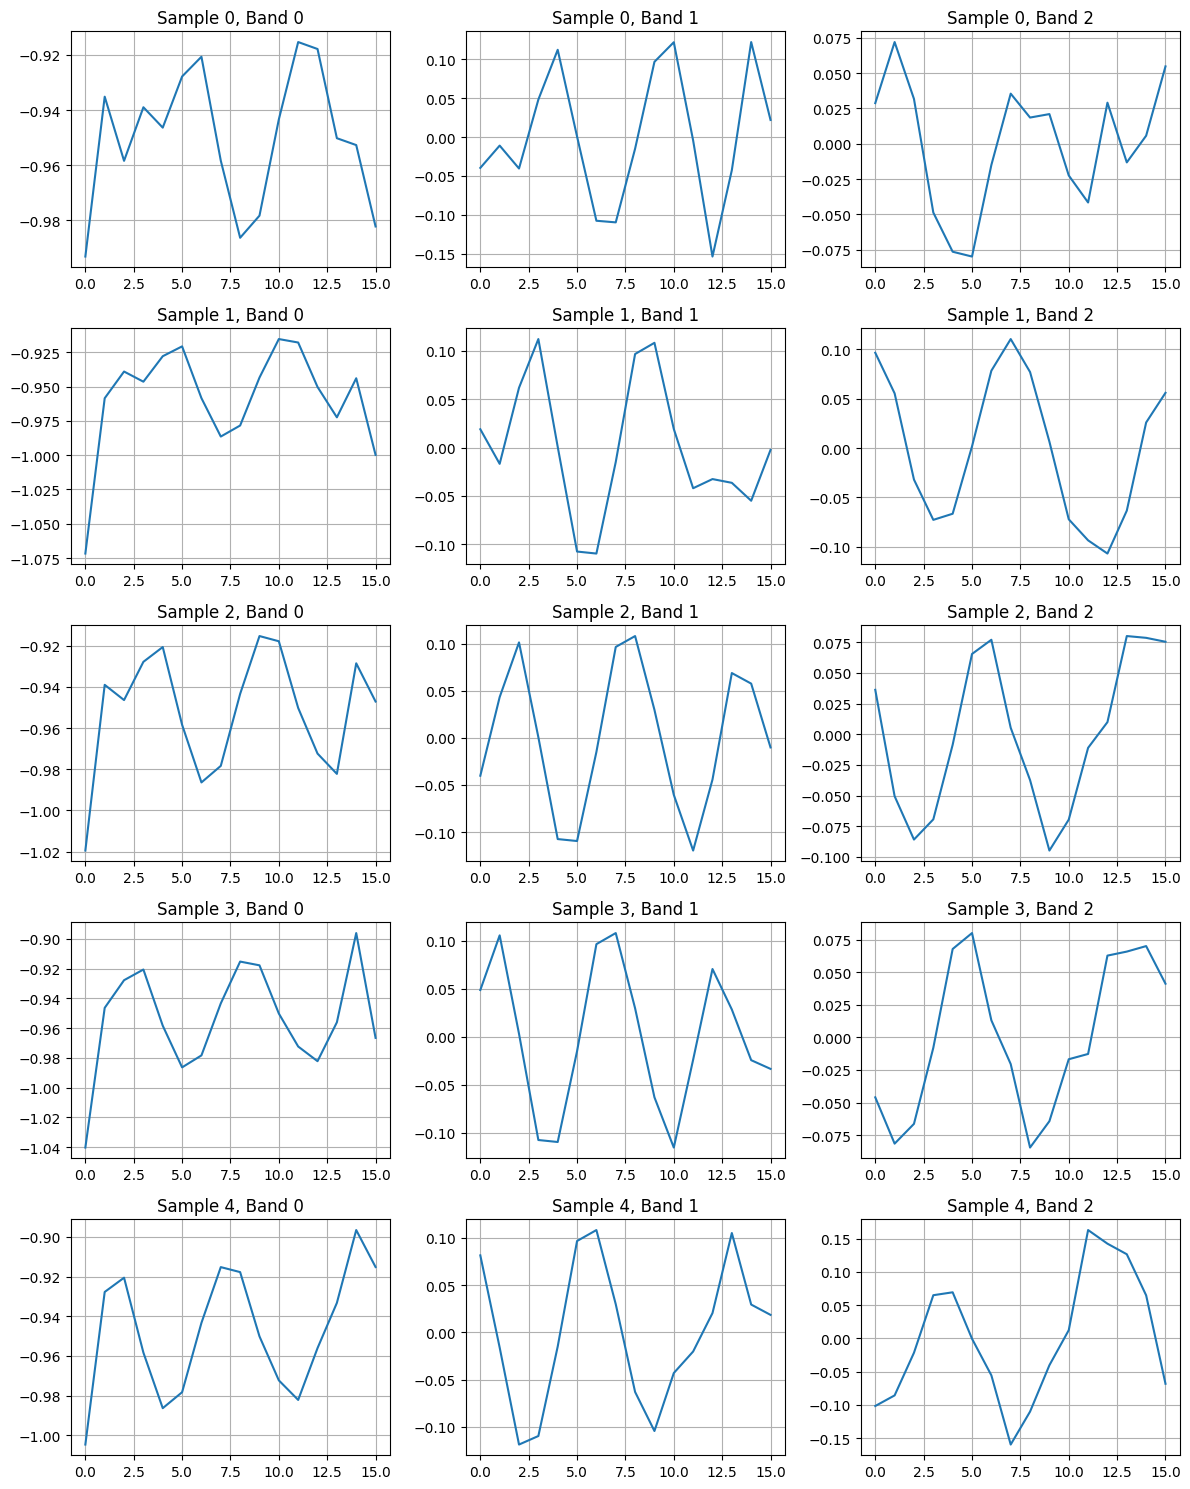

In [30]:
plot_input_bands_from_tensors(X_train_tensors)

In [31]:
import matplotlib.pyplot as plt

def plot_band_histograms(X_train_tensors, bins=50):
    n_bands = len(X_train_tensors)
    plt.figure(figsize=(5 * n_bands, 4))

    for i in range(n_bands):
        data = X_train_tensors[i].cpu().detach().numpy().flatten()
        plt.subplot(1, n_bands, i + 1)
        plt.hist(data, bins=bins, alpha=0.7, edgecolor='black')
        plt.title(f'Band {i} Histogram')
        plt.xlabel('Value')
        plt.ylabel('Frequency')
        plt.grid(True)

    plt.tight_layout()
    plt.show()


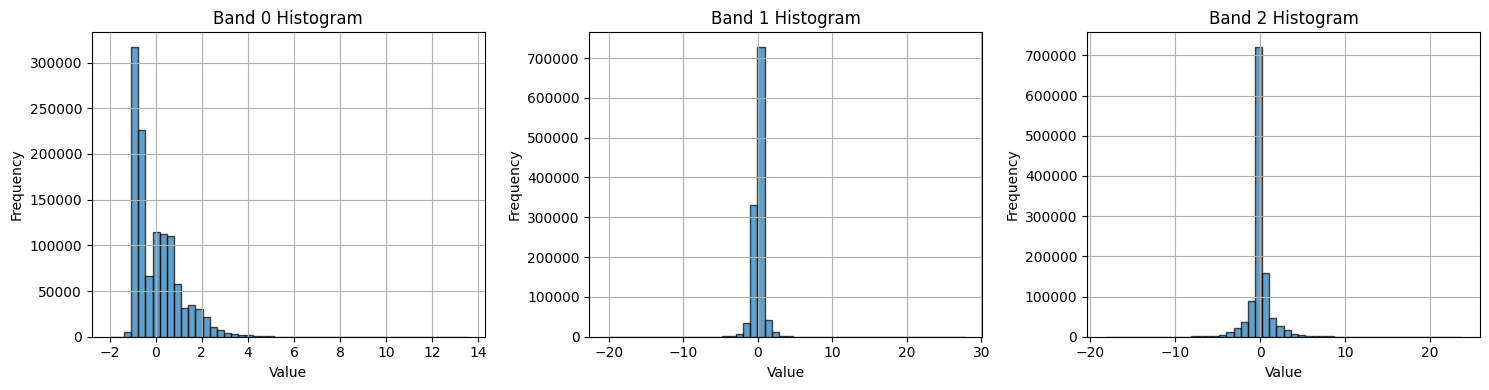

In [22]:
plot_band_histograms(X_train_tensors)

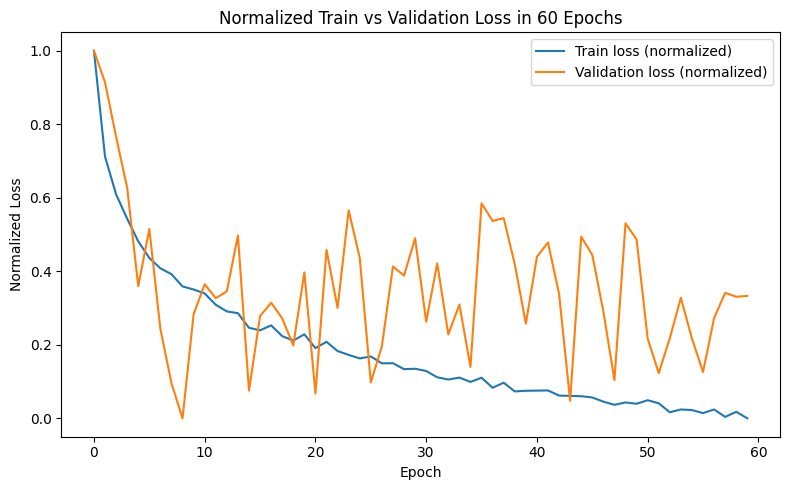

In [32]:
import pandas as pd
from matplotlib import pyplot as plt

df = pd.read_csv('logs/train_log_60.csv')

# Min-max normalization
train_min = df['train_loss'].min()
train_max = df['train_loss'].max()
val_min = df['val_loss'].min()
val_max = df['val_loss'].max()

df['train_loss_norm'] = (df['train_loss'] - train_min) / (train_max - train_min)
df['val_loss_norm'] = (df['val_loss'] - val_min) / (val_max - val_min)

plt.figure(figsize=(8, 5))
plt.plot(df['train_loss_norm'].values, label="Train loss (normalized)", )
plt.plot(df['val_loss_norm'].values, label="Validation loss (normalized)")
plt.title("Normalized Train vs Validation Loss in 60 Epochs")
plt.xlabel("Epoch")
plt.ylabel("Normalized Loss")
plt.legend()
plt.tight_layout()
plt.show()


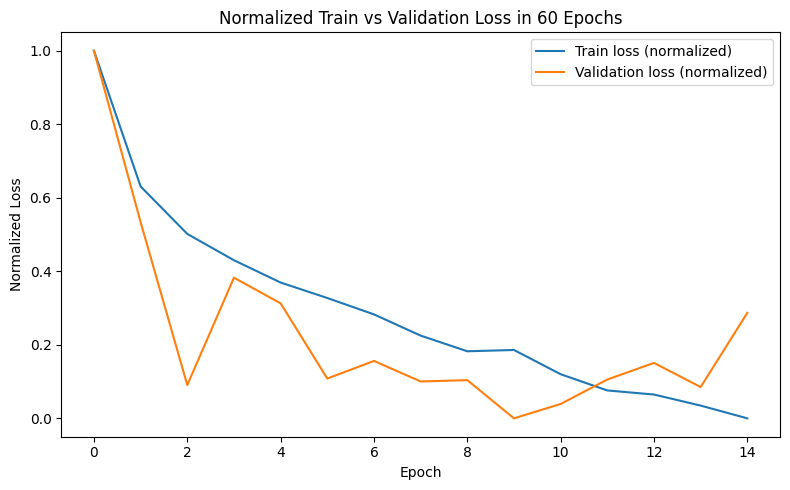

In [34]:
import pandas as pd
from matplotlib import pyplot as plt

df = pd.read_csv('logs/train_log.csv')

# Min-max normalization
train_min = df['train_loss'].min()
train_max = df['train_loss'].max()
val_min = df['val_loss'].min()
val_max = df['val_loss'].max()

df['train_loss_norm'] = (df['train_loss'] - train_min) / (train_max - train_min)
df['val_loss_norm'] = (df['val_loss'] - val_min) / (val_max - val_min)

plt.figure(figsize=(8, 5))
plt.plot(df['train_loss_norm'].values, label="Train loss (normalized)", )
plt.plot(df['val_loss_norm'].values, label="Validation loss (normalized)")
plt.title("Normalized Train vs Validation Loss in 60 Epochs")
plt.xlabel("Epoch")
plt.ylabel("Normalized Loss")
plt.legend()
plt.tight_layout()
plt.show()


In [35]:
import torch
import numpy as np
import pywt
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error


def swt_reconstruct_from_preds(pred_bands, wavelet='db2', scaler_y=None):
    aN = pred_bands[0]  # a2

    if scaler_y is not None:
        aN = scaler_y.inverse_transform(aN.reshape(1, -1)).flatten()

    coeffs = [(aN, d) for d in pred_bands[1:]]  # [(a2, d2), (a2, d1)]
    return pywt.iswt(coeffs, wavelet)

def evaluate_model(model_path, test_loader, y_test, scaler_y, forecast_steps, wavelet='db2'):
    model = torch.load(model_path)
    model.eval()

    preds_scaled = []
    y_true = []

    with torch.no_grad():
        for *x_bands, y_batch in test_loader:
            x_tensor = torch.stack(x_bands, dim=1)  # [B, bands, W, 1]
            out = model(x_tensor)                   # [B, bands, s, 1]
            out = out.detach().cpu().numpy().squeeze(-1)  # [B, bands, s]

            B, bands, s = out.shape
            for b in range(B):
                band_preds = out[b]  # [bands, s]
                recon = swt_reconstruct_from_preds(band_preds, wavelet=wavelet, scaler_y=scaler_y)
                preds_scaled.append(torch.tensor(recon[-s:], dtype=torch.float32))
                y_true.append(y_batch[b].detach().cpu())

    preds_scaled = torch.stack(preds_scaled)  # [B, s]

    # Only apply inverse_transform to predictions if a2 was scaled
    preds_unscaled = preds_scaled.view(-1).numpy()
    pred_unrolled = preds_unscaled.reshape(-1, forecast_steps)[:, 0]

    # === Metrics ===
    mae = mean_absolute_error(y_test, pred_unrolled)
    mse = mean_squared_error(y_test, pred_unrolled)
    mape = mean_absolute_percentage_error(y_test, pred_unrolled)

    print("\n📊 Final Flattened Evaluation:")
    print(f"MAE:  {mae:.4f}")
    print(f"MSE:  {mse:.4f}")
    print(f"MAPE: {mape:.2%}")


    plt.figure(figsize=(30, 7))
    plt.plot(y_test, color='blue', linewidth=0.5, label='True Values')
    plt.plot(pred_unrolled, color='red', linewidth=0.5, label='Predicted Values')
    plt.title("Predicted vs True Values per Sequence")
    plt.xlabel("Forecast Step")
    plt.ylabel("Rescaled Value")
    plt.legend()
    plt.tight_layout()
    plt.show()

    return mae, mse, mape



C:\Users\janav\AppData\Local\Temp\ipykernel_26472\1956371083.py:18: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load(model_path)



📊 Final Flattened Evaluation:
MAE:  1.0170
MSE:  2.7436
MAPE: 40.83%


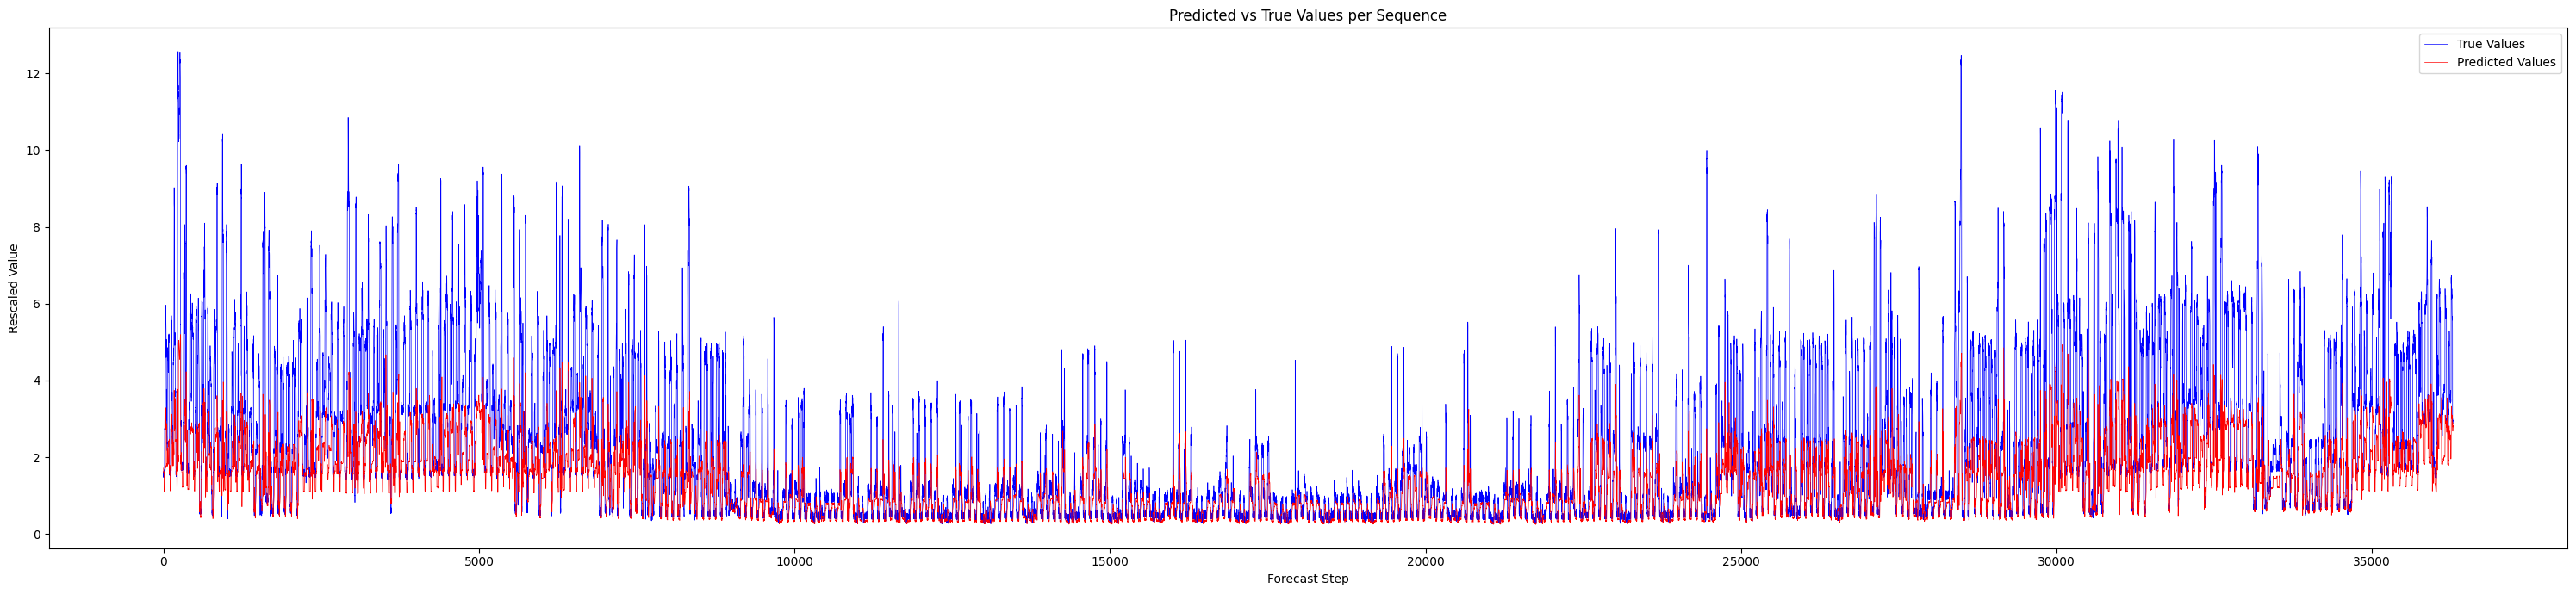

In [36]:
mae, mse, mape = evaluate_model(
    model_path="models/model.pth",
    test_loader=test_loader,
    scaler_y=scalers_y[0],
    y_test=y_test[:, 0],
    forecast_steps=args['s'],
    wavelet=args['wavelet']
)

In [72]:
import torch
import numpy as np
import pywt
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error


def autoregressive_forecast_strict(model_path, val_loader, scaler_y, y_test, forecast_steps, wavelet='db2', level=3):
    model = torch.load(model_path, map_location='cuda' if torch.cuda.is_available() else 'cpu')
    model.eval()
    device = next(model.parameters()).device

    # === INITIAL CONTEXT FROM VALIDATION ===
    val_batch = list(val_loader)[-1]
    num_bands = len(val_batch) // 2
    seq = [x[-1].squeeze(-1).cpu().numpy().flatten().tolist() for x in val_batch[:num_bands]]

    preds = []
    true_recon = []

    with torch.no_grad():
        for t in range(0, len(y_test) - forecast_steps + 1, forecast_steps):
            current_input = np.array(seq[0][-48:])  # using last 48 samples of a3

            # Decompose input into SWT bands
            coeffs = pywt.swt(current_input, wavelet=wavelet, level=level)
            input_bands = []
            for j in range(len(coeffs)):
                a, d = coeffs[j]
                band = a if j == 0 else d
                band_tensor = torch.tensor(band, dtype=torch.float32).unsqueeze(0).unsqueeze(-1)
                input_bands.append(band_tensor)

            x_tensor = torch.stack(input_bands, dim=1).to(device)  # [1, bands, W, 1]
            out = model(x_tensor)  # [1, bands, s, 1]
            out_np = out.squeeze(0).squeeze(-1).cpu().numpy()  # [bands, s]

            a3_pred = scaler_y.inverse_transform(out_np[0].reshape(1, -1)).flatten()
            detail_preds = out_np[1:]

            # ⛏️ Dynamically pair a3 with all predicted detail bands
            pred_coeffs = [(a3_pred, d) for d in detail_preds]

            recon_pred = pywt.iswt(pred_coeffs, wavelet=wavelet)
            preds.append(recon_pred[-forecast_steps:])

            # Ground truth
            true_seq = y_test[t:t + forecast_steps]
            if len(true_seq) < forecast_steps:
                break

            true_coeffs = pywt.swt(true_seq, wavelet=wavelet, level=len(pred_coeffs))
            true_recon_coeffs = [(true_coeffs[i][0], true_coeffs[i][1]) for i in range(len(pred_coeffs))]

            recon_true = pywt.iswt(true_recon_coeffs, wavelet=wavelet)
            true_recon.append(recon_true[-forecast_steps:])

            # Extend sequence autoregressively
            for b in range(len(seq)):
                seq[b].extend(out_np[b])

    preds_flat = np.concatenate(preds)
    # Ensure lengths match (clip to shortest)
    min_len = min(len(y_test), len(preds_flat))
    y_test = y_test[:min_len]
    preds_flat = preds_flat[:min_len]

    print(y_test.shape, preds_flat.shape)

    # === Evaluation ===
    mae = mean_absolute_error(y_test[:, 0], preds_flat)
    mse = mean_squared_error(y_test[:, 0], preds_flat)
    mape = mean_absolute_percentage_error(y_test[:, 0], preds_flat)

    print("\n📊 Strict Autoregressive Evaluation:")
    print(f"MAE:  {mae:.4f}")
    print(f"MSE:  {mse:.4f}")
    print(f"MAPE: {mape:.2%}")

    plt.figure(figsize=(30, 7))
    plt.plot(y_test[:, 0], color='blue', label="True", linewidth=0.5)
    plt.plot(preds_flat, color='red', label="Predicted", linewidth=0.5)
    plt.title("Strict Autoregressive Forecast vs True Values")
    plt.xlabel("Time Step")
    plt.ylabel("Value")
    plt.legend()
    plt.tight_layout()
    plt.show()

    return mae, mse, mape


C:\Users\janav\AppData\Local\Temp\ipykernel_26472\1251745911.py:9: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load(model_path, map_location='cuda' if torch.

(36280, 8) (36280,)

📊 Strict Autoregressive Evaluation:
MAE:  2.5267
MSE:  8.2630
MAPE: 322.72%


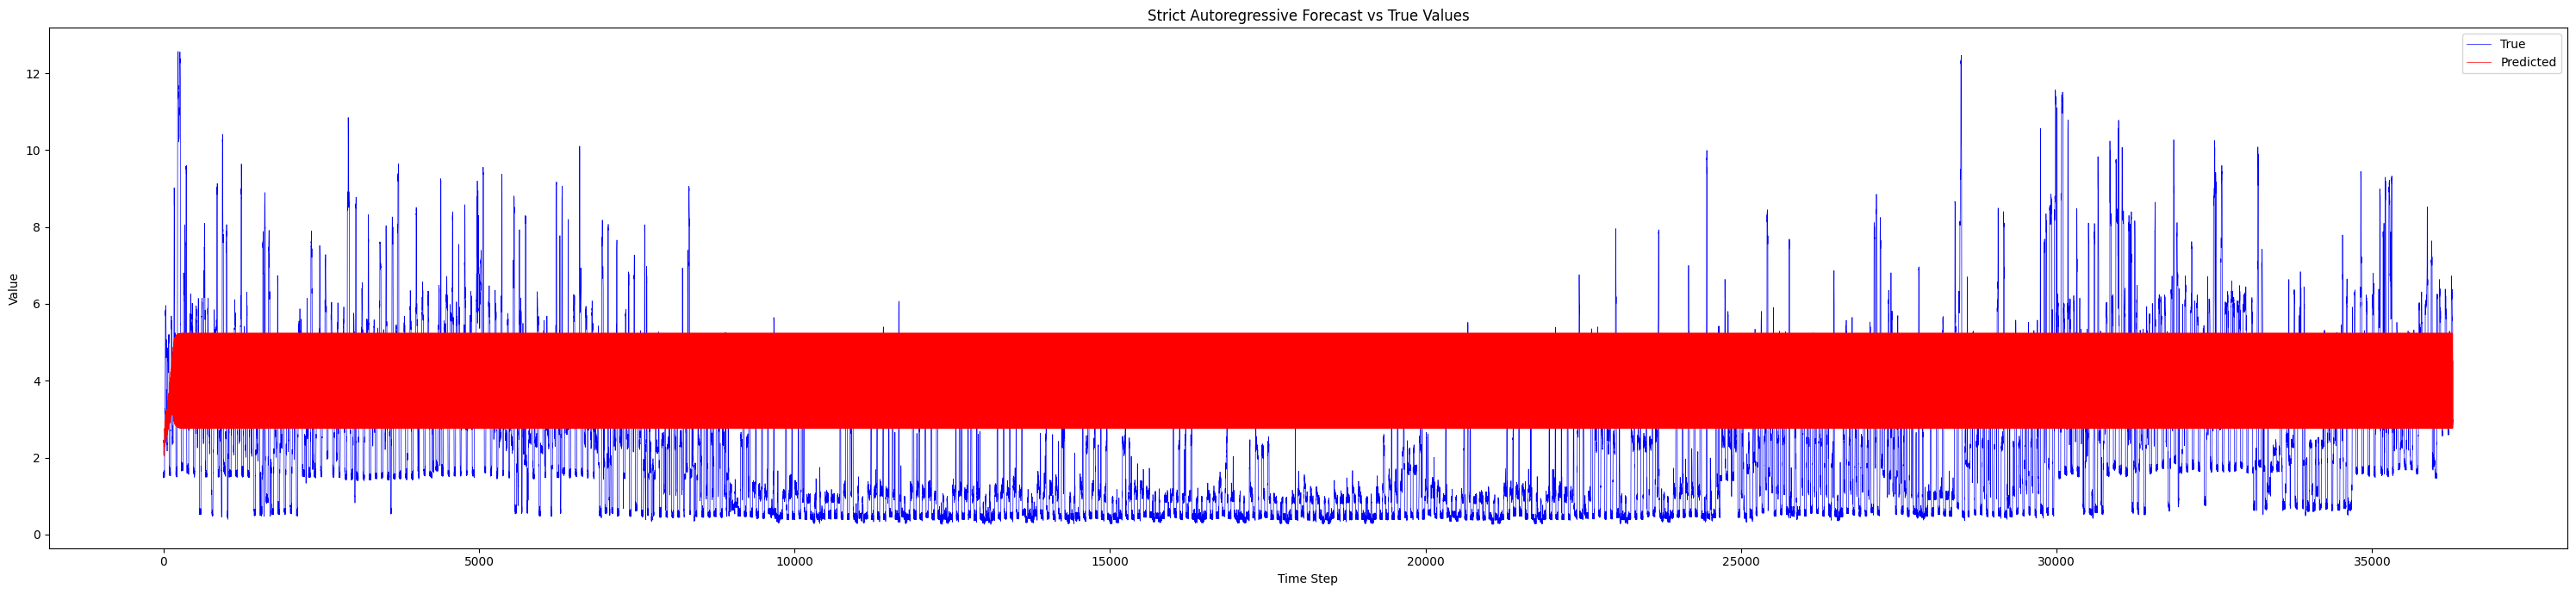

(2.5267005617597533, 8.263045854926954, 3.2272104273774835)

In [73]:
autoregressive_forecast_strict('models/model.pth', val_loader, scalers_y[0], y_test, args['s'], wavelet='db2', level=3)